In [1]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error,roc_auc_score
from math import sqrt
from sklearn import preprocessing
from sklearn.metrics import recall_score,precision_score

In [2]:
final_dataset=pd.read_csv("nan_clean_dataset.csv")
final_dataset['date'] =pd.to_datetime(final_dataset.date)
final_dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'business_id', 'review_id',
       'rating', 'date', 'useful_x', 'funny_x', 'cool_x', 'text', 'name_x',
       'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'stars', 'review_count_x', 'category', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'GoodForKids', 'HasTV',
       'RestaurantsGoodForGroups', 'RestaurantsReservations', 'WiFi',
       'RestaurantsAttire', 'Alcohol', 'OutdoorSeating', 'RestaurantsDelivery',
       'BikeParking', 'average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool_y',
       'elite', 'fans', 'friends', 'funny_y', 'name_y', 'review_count_y',
       'useful_y', 'yelping_since'],
      dtype='object')

In [3]:
df_sample2 = final_dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1','elite','address','state','postal_code','latitude','longitude'])


#  ALS model 

# Creating a dictionary for mapping user_id and business_id to integer values

In [8]:
uidmapping=dict()
c=0
for i in df_sample2['user_id']:
    uidmapping[i]=c
    c=c+1
bidmapping=dict()
c=0
for i in df_sample2['business_id']:
    bidmapping[i]=c
    c=c+1

In [10]:
l = []
for i in df_sample2['user_id']:
     l.append(uidmapping[i])
df_sample2['UID'] = l

l = []
for i in df_sample2['business_id']:
     l.append(bidmapping[i])
df_sample2['BID'] = l

In [12]:
df=df_sample2.groupby(['UID']).date.apply(lambda x: max(x)).reset_index()
df_test = pd.merge(df_sample2,df, how='inner',on=['UID','date'])

In [13]:
df_train=df_sample2[~df_sample2.isin(df_test.to_dict('l')).all(1)]


In [14]:
df_train[['UID','BID','rating']].to_csv('df_train.csv')
df_test[['UID','BID','rating']].to_csv('df_test.csv')

In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import min,max,avg,col
spark = SparkSession.builder.appName('recommend').getOrCreate()

In [16]:
train_ratings = spark.read.csv('df_train.csv', inferSchema=True, header=True)
test_ratings = spark.read.csv('df_test.csv', inferSchema=True, header=True)

train_ratings.printSchema()
test_ratings.printSchema()
print(train_ratings.show(n = 5))


root
 |-- _c0: integer (nullable = true)
 |-- UID: integer (nullable = true)
 |-- BID: integer (nullable = true)
 |-- rating: double (nullable = true)

root
 |-- _c0: integer (nullable = true)
 |-- UID: integer (nullable = true)
 |-- BID: integer (nullable = true)
 |-- rating: double (nullable = true)

+---+---+------+------+
|_c0|UID|   BID|rating|
+---+---+------+------+
|  0|  3| 16295|   5.0|
|  1|  3| 26762|   1.0|
|  3|  3| 28346|   2.0|
|  4|424| 16295|   2.0|
|  5|424|328297|   4.0|
+---+---+------+------+
only showing top 5 rows

None


In [27]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    colors=['b', 'g', 'r', 'c', 'm', 'y', 'k']
    min_RMSE = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    mse1=[]
    for i,rank in enumerate(ranks):
        mse=[]
        RMSE1=[]
        for reg in reg_param:
            als = ALS(userCol="UID", itemCol="BID", ratingCol="rating", maxIter=num_iters, rank=rank,
                      regParam=reg,coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
            model = als.fit(train_data)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
            evaluator1 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
            test_predictions = model.transform(validation_data)
            RMSE = evaluator.evaluate(test_predictions)
            MSE = evaluator1.evaluate(test_predictions)
            RMSE1.append(RMSE)
            mse.append(MSE)
            print('for rank ',rank,'regularization parameter ',reg,'rmse is', RMSE,'MSE is', MSE)
            if RMSE < min_RMSE:
                min_RMSE = RMSE
                best_rank = rank
                best_regularization = reg
                best_model = model
        mse1.append(mse)
        plt.plot(reg_param, RMSE1,marker='o',color=colors[i],label='rank'+str(rank))
        
    plt.xlabel('regularization parameters')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    for i in range(len(mse1)):
        plt.plot(reg_param, mse1[i],marker='o',color=colors[i],label='rank'+str(ranks[i]))
    plt.xlabel('regularization parameters')
    plt.ylabel('MSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

for rank  10 regularization parameter  0.05 rmse is 1.4545227242108065 MSE is 2.1156363552456257
for rank  10 regularization parameter  0.1 rmse is 1.3707433287025683 MSE is 1.878937273182597
for rank  10 regularization parameter  0.15 rmse is 1.3192057579401408 MSE is 1.7403038317824213
for rank  10 regularization parameter  0.3 rmse is 1.2713320103747279 MSE is 1.616285080603447
for rank  13 regularization parameter  0.05 rmse is 1.4457174203945442 MSE is 2.0900988596322554
for rank  13 regularization parameter  0.1 rmse is 1.3656431320243467 MSE is 1.8649811640452674
for rank  13 regularization parameter  0.15 rmse is 1.3182839236258022 MSE is 1.7378725032902398
for rank  13 regularization parameter  0.3 rmse is 1.270974308198496 MSE is 1.615375692100646
for rank  17 regularization parameter  0.05 rmse is 1.4271549079771932 MSE is 2.036771131363391
for rank  17 regularization parameter  0.1 rmse is 1.3569680693968509 MSE is 1.8413623413626166
for rank  17 regularization parameter  0

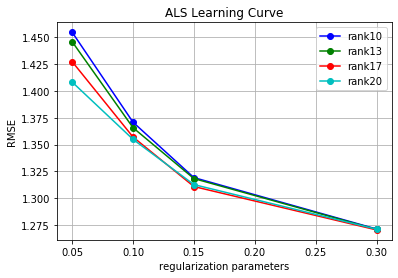

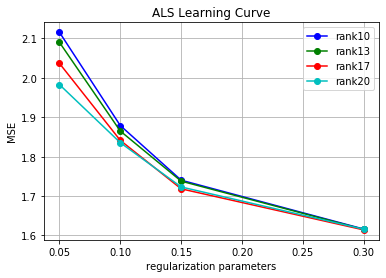


The best model has 17 latent factors and regularization = 0.3


In [28]:
best_model=train_ALS(train_ratings,test_ratings,10,[.05, .1, .15,0.3],[10,13,17,20])

# Fit ALS on training data

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

als = ALS(userCol="UID", itemCol="BID", ratingCol="rating", maxIter=10, rank=17,
                      regParam=0.3, coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
model1=als.fit(train_ratings)

# Model Evaluation 

In [22]:
test_predictions1=model1.transform(test_ratings)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
evaluator1 = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(test_predictions1)
MSE = evaluator1.evaluate(test_predictions1)
print('The ALS model gives rmse value of {} and mse value of {} on test data'.format(RMSE,MSE))


The ALS model gives rmse value of 1.2704955345064337 and mse value of 1.6141589032007888 on test data
